# 2019.07.13 - EDA 2

## 미국 통계 데이터 - 5만 달러 이상 버는 사람의 특징

- 나이
- 직업
- 교육년수
- 가족 구성원
- 성별
- 주당 근무시간
- 5만달러 이상 / 이하 여부

---

**월급이 높은 사람의 특징 추측**

- 높은 경력
- 높은 학력
- 전문 직업군

## 데이터 탐색

- income (소득, 범주형): >50K, <=50K
- age (나이, 연속형)
- workclass (직업군, 범주형)
  - Private
  - Self-emp-not-inc (자영업자)
  - Self-emp-inc  (프리랜서)
  - Federal-gov (연방정부기관)
  - Local-gov (지역공공기관)
  - State-gov (주공공기관)
  - Without-pay (무급)
  - Never-worked (일하지 않음)
  
<br>

- education-num (교육년수, 연속형)
- marital-statis (혼인관계, 범주형)
  - Married_civ_spouse
  - Divorced
  - Never-married
  - Separated
  - Widowed
  - Married-spouse-absent
  - Married-AF-spouse

<br>

- relationship (가족관계, 범주형)
  - Wife
  - Own-child
  - Husband
  - Not-in-family
  - Other-relative
  - Unmarried

<br>

- sex (성별, 범주형)
  - Female
  - Male

<br>

- hours-per-week (주당 근무시간, 연속형)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('../data/adult.csv')
df = df[[
    'age',
    'workclass',
    'education.num',
    'marital.status',
    'relationship',
    'sex',
    'hours.per.week',
    'income',
]]
df.tail()

,age,workclass,education.num,marital.status,relationship,sex,hours.per.week,income
32556,22,Private,10,Never-married,Not-in-family,Male,40,<=50K
32557,27,Private,12,Married-civ-spouse,Wife,Female,38,<=50K
32558,40,Private,9,Married-civ-spouse,Husband,Male,40,>50K
32559,58,Private,9,Widowed,Unmarried,Female,40,<=50K
32560,22,Private,9,Never-married,Own-child,Male,20,<=50K


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 8 columns):
age               32561 non-null int64
workclass         32561 non-null object
education.num     32561 non-null int64
marital.status    32561 non-null object
relationship      32561 non-null object
sex               32561 non-null object
hours.per.week    32561 non-null int64
income            32561 non-null object
dtypes: int64(3), object(5)
memory usage: 2.0+ MB


In [3]:
# 범주형 자료 확인
for col_name in df.select_dtypes(object):
    print(f'Column Name:{col_name}, Number of values: {len(df[col_name].unique())}')
    print(f'Values: {df[col_name].unique()}\n')

Column Name:workclass, Number of values: 9
Values: ['?' 'Private' 'State-gov' 'Federal-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Local-gov' 'Without-pay' 'Never-worked']

Column Name:marital.status, Number of values: 7
Values: ['Widowed' 'Divorced' 'Separated' 'Never-married' 'Married-civ-spouse'
 'Married-spouse-absent' 'Married-AF-spouse']

Column Name:relationship, Number of values: 6
Values: ['Not-in-family' 'Unmarried' 'Own-child' 'Other-relative' 'Husband' 'Wife']

Column Name:sex, Number of values: 2
Values: ['Female' 'Male']

Column Name:income, Number of values: 2
Values: ['<=50K' '>50K']



## 결측치 처리 (Imputation)

Null (or NaN)이 있는 경우에는 제대로 된 연산이 되지 않기 때문에 이를 처리해야한다.  
Null 을 결측치 라고 부르며, 처리과정을 결측치 처리라고 한다.  

<br>

### 결측치 처리 방법

- 결측치 데이터 행 삭제 \-\-> Bias 가 최고로 올라간다. (데이터 편식이므로 권장 X)
- 일반 값으로 대체 (0, 평균값, 최빈값 등)
- 시뮬레이션 등 통계적 방법론을 이용하여 값 예측

<br>

**본 분석에서는 '최빈값' 으로 대체하는 방법을 사용한다.**

In [4]:
idx_nan = df['workclass'] == '?'
mode_val = df['workclass'].value_counts().index[0]  # 최빈값 Private
# mode 는 최빈값이라는 의미를 가지고 있다.
df['workclass'][idx_nan] = mode_val  # '?' 가 Private 으로 변경

In [5]:
# unique 결과에서 '?' 가 Priavte 으로 변경되어 사라진 것을 확인가능.
df['workclass'].unique()

array(['Private', 'State-gov', 'Federal-gov', 'Self-emp-not-inc',
       'Self-emp-inc', 'Local-gov', 'Without-pay', 'Never-worked'],
      dtype=object)

In [6]:
df.describe()

,age,education.num,hours.per.week
count,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,40.437456
std,13.640433,2.572720,12.347429
min,17.000000,1.000000,1.000000
25%,28.000000,9.000000,40.000000
50%,37.000000,10.000000,40.000000
75%,48.000000,12.000000,45.000000
max,90.000000,16.000000,99.000000


## EDA

### 상관관계 매트릭스: 양적 변수들간의 상관관계 분석

상관분석: 두 개의 양적 변수가 선형관계를 가지고 있는지 확인  

상관관계를 통해 가설을 구체적으로 만들 수 있다.

> 온도가 오르면 아이스크림 판매량 증가 \-\-\> 인과관계 X, 상관관계 O

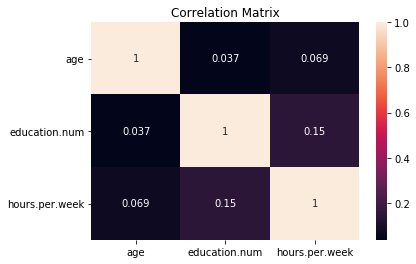

In [7]:
# 상관관계 매트릭스 그리기
corrmat = df.corr()

sns.heatmap(corrmat, annot=True)
plt.title('Correlation Matrix')
plt.show()

**각 양적 변수들간 상관관계가 거의 없는 것을 확인 가능**

- 대각선 해석 X
- (교육년수, 나이) \-\-\> 상관계수 0.037 (큰 의미 X)
- (나이, 주당 근무시간) \-\-\> 상관계수 0.069 (큰 의미 X)
- (교육년수, 주당 근무시간) \-\-\> 상관계수 0.15 (아주 작은 양의 상관성)

## 연속형 변수

- 나이
- 교육년수
- 주당 근무시간

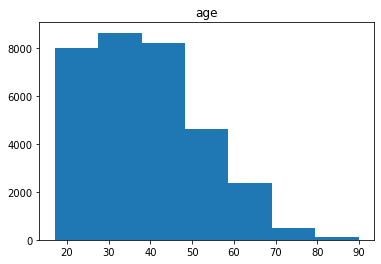

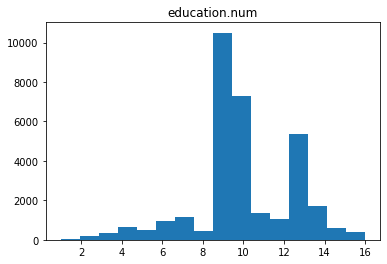

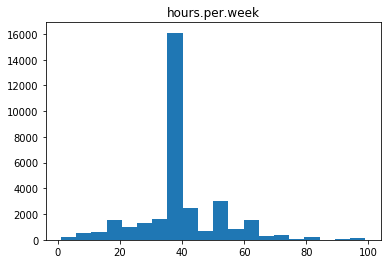

In [8]:
# Histogram - 나이
plt.hist(df['age'], bins=7)
plt.title('age')
plt.show()

# Historgram - 교육년수
plt.hist(df['education.num'], bins=16)
plt.title('education.num')
plt.show()

# Historgram - 주당 근무시간
plt.hist(df['hours.per.week'], bins=20)
plt.title('hours.per.week')
plt.show()

- 나이: 대략 10대 후반 ~ 80대
- 주당 근로시간: 약 40시간

### 나이와 소득

- 나이가 많을 수록 연봉 상승: 연차에 따른 결과로 추측
- 50대 이후로 하락

In [9]:
# Up50K: 소득이 5만 이상 1, 아니면 0
df['Up50K'] = np.where(df.income == '<=50K', 0, 1)
df.drop(['income'], axis=1, inplace=True)

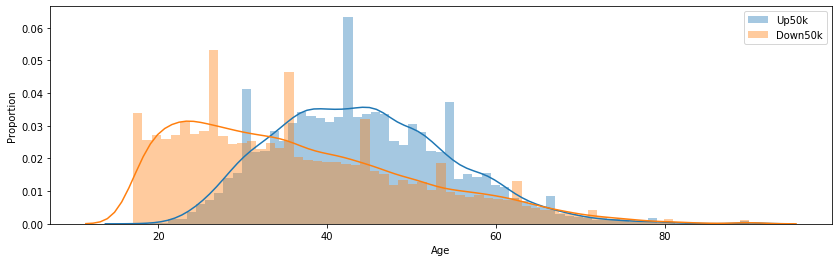

In [10]:
# 나이
age_up50k = df['age'][df.Up50K == 1]
age_down50k = df['age'][df.Up50K == 0]

plt.figure(figsize=(14,4))
sns.distplot(age_up50k, label='Up50k', bins=65)
sns.distplot(age_down50k, label='Down50k', bins=65)
plt.xlabel('Age')
plt.ylabel('Proportion')
plt.legend()
plt.show()

### 교육년수와 소득

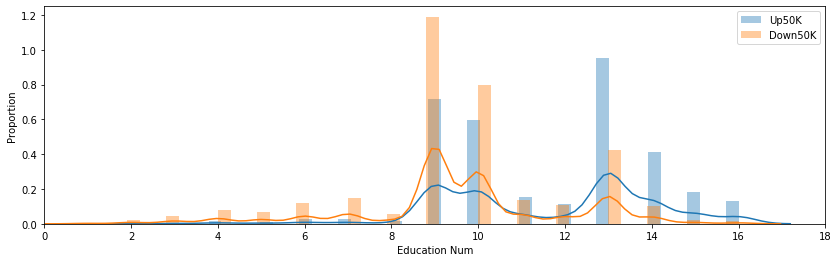

In [11]:
edu_num_down50k = df.loc[df.Up50K == 0]['education.num']
edu_num_up50k = df.loc[df.Up50K == 1]['education.num']

plt.figure(figsize=(14,4))
sns.distplot(edu_num_up50k, label='Up50K')
sns.distplot(edu_num_down50k, label='Down50K')
plt.xlabel('Education Num')
plt.ylabel('Proportion')
plt.xlim(0, 18)
plt.legend()
plt.show()

- 본격적인 커리어 시작이 교육년수 9년 이상부터 시작된다고 추측가능  
(의무교육 기간을 고려했을 때 타당성 있는 추측)

- 교육년수가 낮을수록 연봉 5만달러 초과가 매우 어려움

- 교육년수 13년(학사) 이상부터 연봉 5만달러 이상 상승

- 겨육년수 16년(박사) 이상에서는 대부분 5만달러 이상

### 주당 근무시간

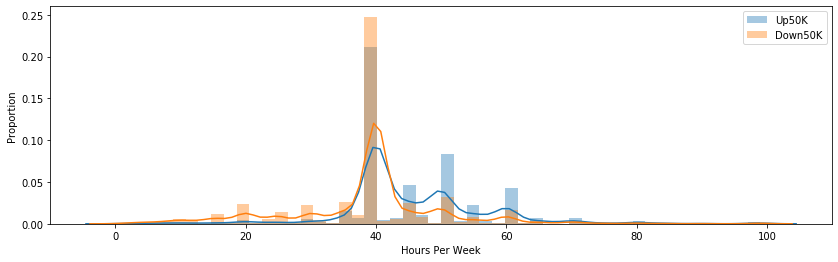

In [12]:
# 주당 근무시간
workhour_up50k = df.loc[df.Up50K == 1]['hours.per.week']
workhour_down50k = df.loc[df.Up50K == 0]['hours.per.week']

plt.figure(figsize=(14,4))
sns.distplot(workhour_up50k, label='Up50K')
sns.distplot(workhour_down50k, label='Down50K')
plt.xlabel('Hours Per Week')
plt.ylabel('Proportion')
plt.legend()
plt.show()

- 근무시간이 길 수록 연봉 상승
- 40시간 이상 근무 시 연봉 5만달러 이상 비중 상승

### 범주형 변수

- 일반적으로 막대 그래프로 형태로 표현

In [13]:
df['Up50K'].sum() / len(df)

0.2408095574460244

**전체의 24% 가 5만달러 초과**

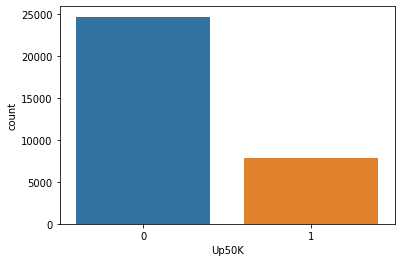

In [14]:
sns.countplot(df['Up50K'])
plt.show()

### 성별

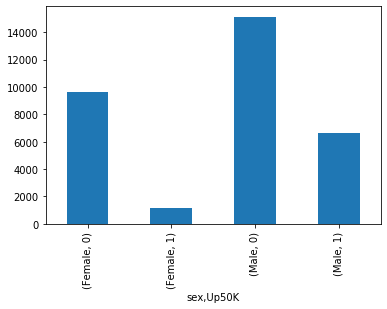

In [15]:
income_by_sex = df.groupby(['sex', 'Up50K']).size()
income_by_sex.plot(kind='bar')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

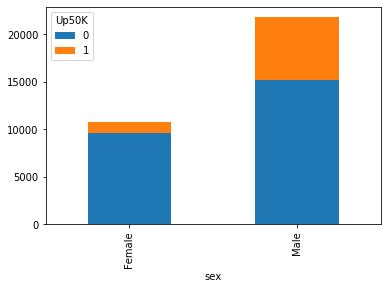

In [16]:
# columns = 행, index = 열, values = 분석할 열의 index
df_plot = income_by_sex.reset_index().pivot(columns='Up50K', index='sex', values=0)
df_plot.plot(kind='bar', stacked=True)
plt.show

**남성의 고소득자 비율이 높음**

### 직업군

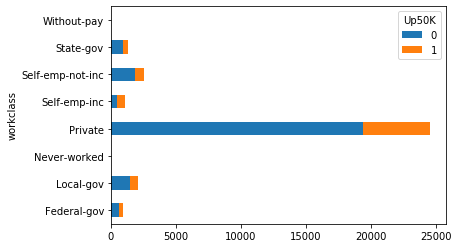

In [17]:
# 직업군
by_workclass = df.groupby(['workclass', 'Up50K']).size()
df_plot = by_workclass.reset_index().pivot(columns='Up50K', index='workclass', values=0)
df_plot.plot(kind='barh', stacked=True)
plt.show()

**대다수가 Private 이지만, Imputation 고려해야한다.**

### 혼인관계

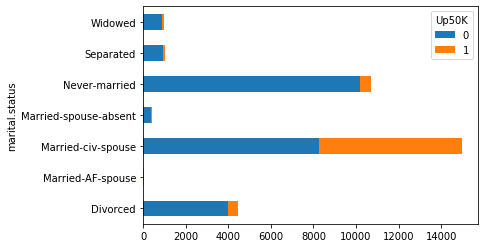

In [18]:
by_marital = df.groupby(['marital.status', 'Up50K']).size()
df_plot = by_marital.reset_index().pivot(columns='Up50K', index='marital.status', values=0)
df_plot.plot(kind='barh', stacked=True)
plt.show()